# MIO PROJEKT 2 - SIECI KOHONENA

In [1]:
import plotly.graph_objects as go
from SOM import *
import seaborn as sns
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, confusion_matrix,f1_score
from scipy.optimize import linear_sum_assignment
import warnings

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon



# neighbourhood functions
def gaussian(x, sigma):
    return np.exp(-(x**2) / (2 * sigma**2))


def gaussian_second_derivative(x, sigma):
    return -(-1 / sigma**2) * (x / sigma)**2 * np.exp(-(x**2) / (2 * sigma**2))


# learning rate decay function
def learning_decay(learning_rate, epoch, decay_coef):
    return learning_rate * np.exp(-epoch / decay_coef)


class SOM:
    def __init__(self, input_dim, map_size, topology='rectangular', X=None):
        self.input_dim = input_dim
        self.map_size = map_size
        self.topology = topology
        self.weights = np.random.randn(*map_size, input_dim)
        if topology == "rectangular":
            self.neighbor_indices = np.indices(self.map_size)
        if topology == "hexagonal":
            self.neighbor_indices = np.indices(self.map_size,dtype=np.float64)
            self.neighbor_indices[0][::2] += 1/2
            self.neighbor_indices[1] *= np.sqrt(3)/2
        
        
        
        

    def train(self, X, epochs, neighborhood_function = gaussian, learning_rate=0.1, sigma=None,learning_rate_decay=None, verbose=False):
        if sigma is None:
            sigma = np.max(self.map_size)
        if learning_rate_decay is None:
            learning_rate_decay = epochs
        
        for epoch in range(epochs):
            if verbose:
                print(f"\r Epoch {epoch+1}/{epochs}",end='')
            current_learning_rate = learning_decay(learning_rate, epoch, learning_rate_decay)
            permutation = np.random.permutation(X.shape[0])
            X_ = X[permutation]
            
            
            for x in X_:
                               
                
                
                # Compute the distances between the input vector and all neurons
                distances = np.linalg.norm(self.weights - x, axis=-1)
                
                # Find the index of the winning neuron
                winner = np.unravel_index(np.argmin(distances), distances.shape)
                
                # Compute the neighborhood function centered around the winner
                neighbor_indices = np.indices(self.map_size)
                neighbor_distances = np.linalg.norm(neighbor_indices - np.array(winner)[:, np.newaxis, np.newaxis], axis=0)
                neighborhood = neighborhood_function(neighbor_distances, sigma)
                
                # Update the weights of all neurons based on the neighborhood function and learning rate
                self.weights += current_learning_rate * neighborhood[..., np.newaxis] * (x - self.weights)
                
    
    
    def find_clusters(self, X):
        # Compute distances between input vectors and all neurons
        winners = []
        for x in X:
                # Compute the distances between the input vector and all neurons
            distances = np.linalg.norm(self.weights - x, axis=-1)
            
            # Find the index of the winning neuron
            winner = np.argmin(distances)
            winners.append(winner)

        return winners


def get_scores_hex(som,X,y):
    y_pred  = som.find_clusters(X)
    h_score = homogeneity_score(y, y_pred)
    c_score = completeness_score(y, y_pred)
    v_score = v_measure_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)


    labels = np.argmax(conf_matrix,axis=0)
    y_pred_relabeled = np.zeros_like(y_pred)
    for i in range(len(y_pred)):
        for j in range(len(labels)):
            if y_pred[i] == j:
                y_pred_relabeled[i] = labels[j]
                break

    
    
    f1 = f1_score(y, y_pred_relabeled, average='macro')
    
    return y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels

In [5]:
def get_scores(som,X,y):
    y_pred  = som.find_clusters(X)
    h_score = homogeneity_score(y, y_pred)
    c_score = completeness_score(y, y_pred)
    v_score = v_measure_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    # Apply the Hungarian algorithm to find the optimal matching between the predicted and true labels
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)


    y_pred_relabeled = np.zeros_like(y_pred)
    for i, j in zip(col_ind, range(len(y_pred))):
        y_pred_relabeled[y_pred == i] = j
    
    f1 = f1_score(y, y_pred_relabeled, average='macro')
    
    return y_pred_relabeled, y_pred,f1, h_score,c_score,v_score


def coefs_search(X,y, input_dim, map_size, epochs, neighborhood_functions, learning_rates, sigmas, decays,allow_warnings=False, debug=False):
    warnings.filterwarnings("error") if not allow_warnings else warnings.filterwarnings("ignore")
    for neighborhood_function in neighborhood_functions:
        for learning_rate in learning_rates:
            for sigma in sigmas:
                for decay in decays:
                    som = SOM(input_dim=input_dim, map_size=map_size)
                    try:
                        som.train(X, epochs=epochs, neighborhood_function=neighborhood_function, learning_rate=learning_rate, sigma=sigma, learning_rate_decay=decay)
                    except Exception as e:
                        if debug:
                            print(e)
                        print(f"Error with parameters: {neighborhood_function=}, {learning_rate=}, {sigma=}, {decay=}")
                    else: 
                        y_pred_relabeled, y_pred,f1, h_score,c_score,v_score = get_scores(som,X,y)
                        print(f"{v_score=} | function={neighborhood_function.__name__}, {learning_rate=}, {sigma=}, {decay=}")
                    
    warnings.filterwarnings("default")




def plot_clusters_2D(som,df):

    y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[['x','y']].values,df['c'])

    errors = df["c"] != y_pred_relabeled
    y_pred = pd.Series(y_pred)

    palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
    all_labels = sorted(set(df["c"]))
    color_map = dict(zip(all_labels, palette))



    fig = plt.figure(figsize=(10,10))
    sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
    sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=100, legend=False)
    plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
    plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
    plt.show()  

In [ ]:
df = pd.read_csv('data/hexagon.csv')
df.head()

,x,y,c
0,2.402047,3.728695,1
1,-0.660032,7.047206,0
2,2.202839,-2.394303,2
3,3.179183,2.593885,1
4,3.173320,-2.152688,2


In [ ]:
neighborhood_functions = [gaussian,gaussian_second_derivative]
learning_rates = [0.1,0.01]
sigmas = [0.1,0.5,1]
decays = [10,100]

In [ ]:
coefs_search(df[["x","y"]].values,df["c"],2,(3,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.9383662598182816 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.9383662598182815 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9323172597177286 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8458718110341035 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.8028270883727716 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.8072562040107152 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.9383662598182818 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.9383662598182816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.8530353651522178 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.905678418962174 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.7883455670810462 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.7670110931328836 | function=ga

In [ ]:
som = SOM(input_dim=2, map_size=(3,2))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian, learning_rate=0.1, sigma=0.1, learning_rate_decay=10)

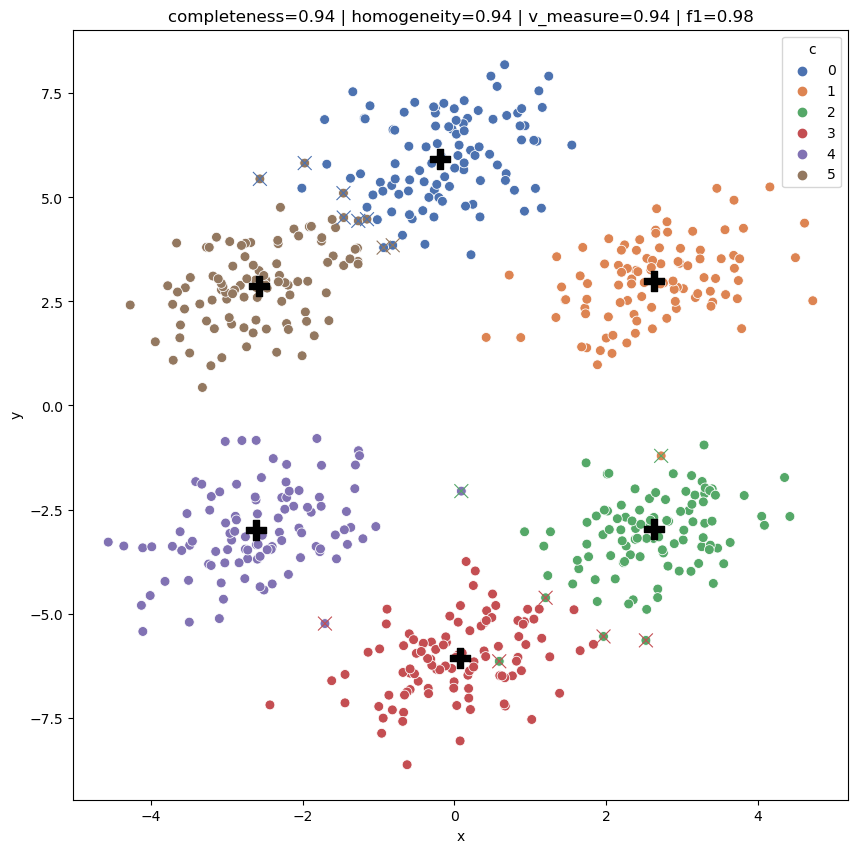

In [ ]:
plot_clusters_2D(som,df)

In [ ]:
som = SOM(input_dim=2, map_size=(3,3))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian_second_derivative, learning_rate=0.1, sigma=2, learning_rate_decay=100)

In [ ]:
som.weights

array([[[-0.00168381, -0.07469648],
        [ 0.00021838, -0.07394218],
        [ 0.00144414, -0.07297642]],

       [[-0.00410841, -0.07727729],
        [-0.00231475, -0.07811655],
        [-0.00056248, -0.07537852]],

       [[-0.00468902, -0.07732348],
        [-0.0037838 , -0.07941167],
        [-0.0018306 , -0.0763787 ]]])

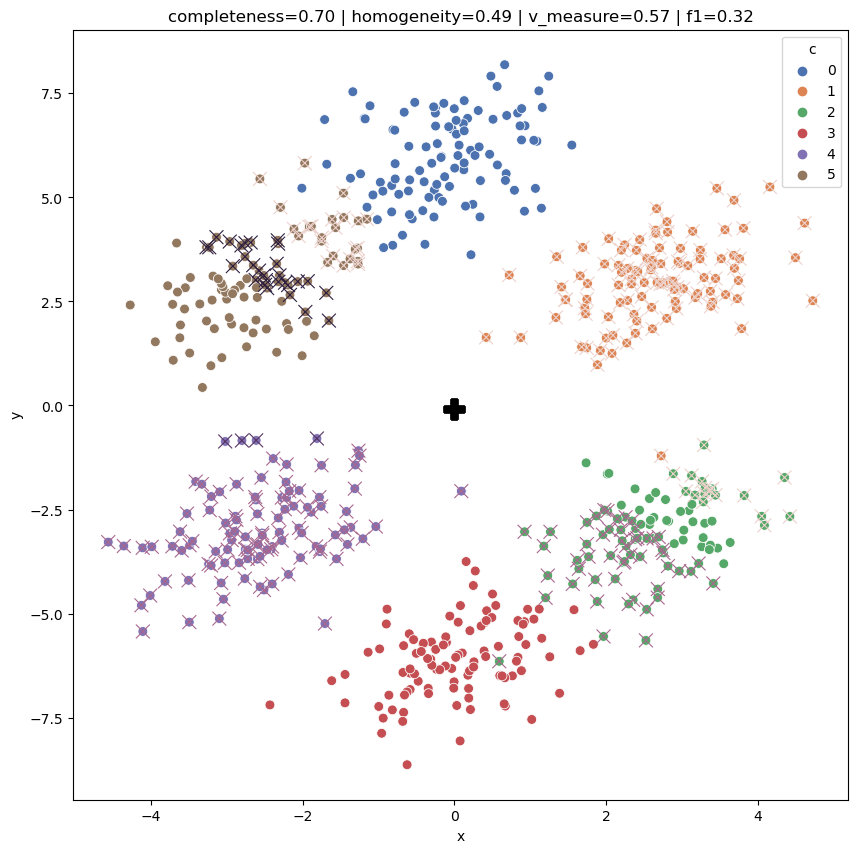

In [ ]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[['x','y']].values,df['c'])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))



fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], marker="x", s=100, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()

In [ ]:
df = pd.read_csv('data/cube.csv')

In [ ]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.8261344075857365 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8533882974349145 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9255084669150828 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8750378277176529 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6995308284584794 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6979636962751447 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.7884220102647198 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.7827765109367816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.7151799001466773 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8826049589833852 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6962317848603436 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.699715198496835 | function=ga

In [ ]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,3),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.829800079828923 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8139697692646883 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.856078903584405 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8463880315684381 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6994959716737736 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6563719469057725 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.8045662344699269 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.8011795206057616 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.859741255939307 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8671383818701168 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6662398240918193 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.701783423948206 | function=gauss

In [ ]:
som = SOM(input_dim=3, map_size=(4,2))
som.train(df[["x","y","z"]].values, epochs=300, neighborhood_function=gaussian, learning_rate=0.01, sigma=0.5, learning_rate_decay=100)

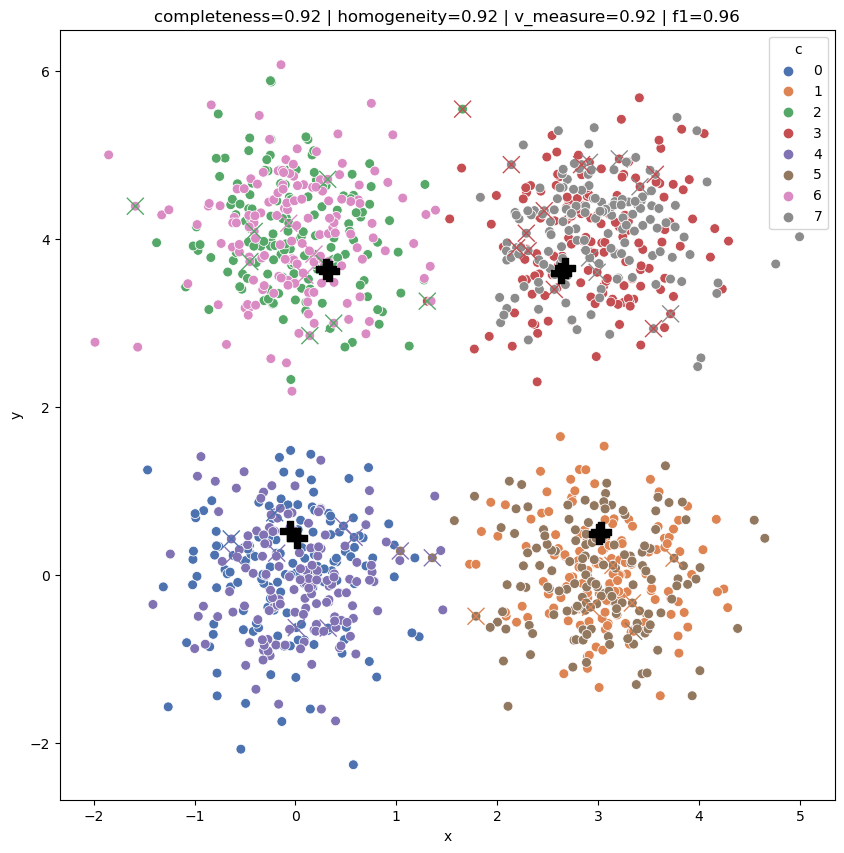

In [ ]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y","z"]].values,df["c"])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))


fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=150, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()  

In [ ]:
warnings.filterwarnings("ignore")
color_map_list = [(k/7, v) for k, v in color_map.items()]

neurons = go.Scatter3d(x=som.weights[:,:,0].flatten(),y=som.weights[:,:,1].flatten(),z=som.weights[:,:,2].flatten(),
                       mode='markers', marker=dict(size=10,color="black",symbol="cross"))
true_markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
wrong_markers = go.Scatter3d(x=df.loc[errors,"x"],y= df.loc[errors,"y"], z=df.loc[errors,"z"], 
                   mode='markers',marker=dict(size=4,color=y_pred_relabeled[errors],colorscale=color_map_list,opacity=0.8,symbol='x'))



fig = go.Figure(data=[neurons,true_markers,wrong_markers])#,marker=dict(size=10,color="black"))])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()
warnings.filterwarnings("default")


In [ ]:
som = SOM(input_dim=3, map_size=(4,2))
som.train(df[["x","y","z"]].values, epochs=100, neighborhood_function=gaussian_second_derivative, learning_rate=0.01, sigma=0.1, learning_rate_decay=10)

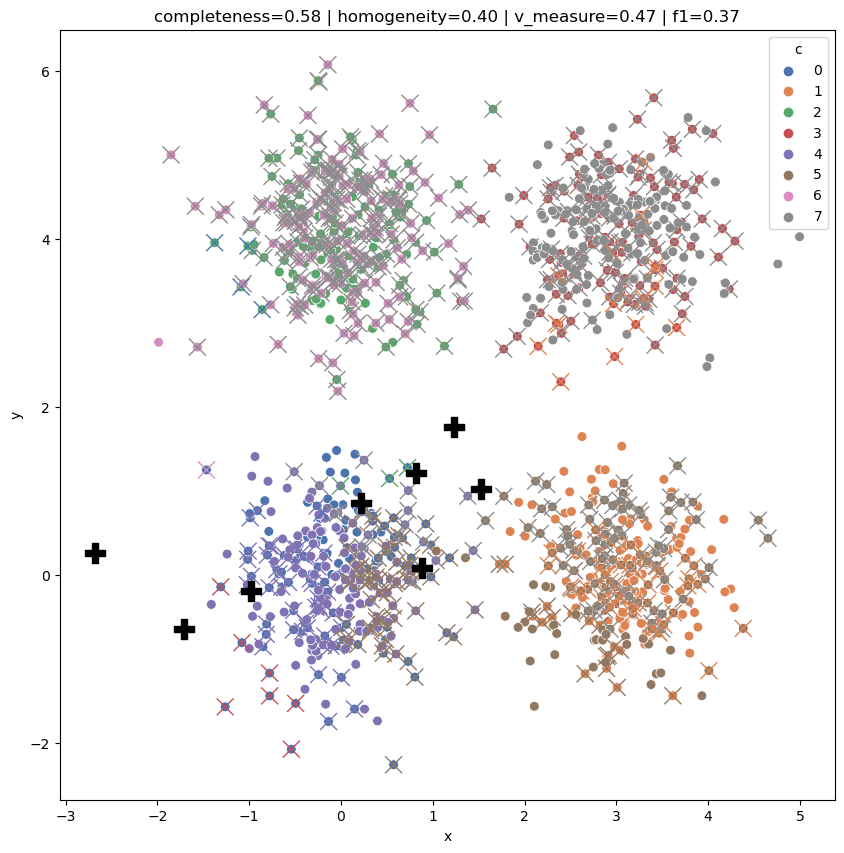

In [ ]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y","z"]].values,df["c"])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))

# Map the true and predicted labels to colors
true_colors = [color_map[label] for label in df["c"]]




fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=150, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()  

In [ ]:
color_map_list = [(k/7, v) for k, v in color_map.items()]

neurons = go.Scatter3d(x=som.weights[:,:,0].flatten(),y=som.weights[:,:,1].flatten(),z=som.weights[:,:,2].flatten(),
                       mode='markers', marker=dict(size=10,color="black",symbol="cross"))
true_markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
wrong_markers = go.Scatter3d(x=df.loc[errors,"x"],y= df.loc[errors,"y"], z=df.loc[errors,"z"], 
                   mode='markers',marker=dict(size=4,color=y_pred_relabeled[errors],colorscale=color_map_list,opacity=0.8,symbol='x'))



fig = go.Figure(data=[neurons,true_markers,wrong_markers])#,marker=dict(size=10,color="black"))])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()

/home/skowronski/miniconda3/envs/mio1/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



___
# Sześciokątna siatka 

In [6]:
import tensorflow as tf

2023-04-21 23:02:52.612707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
(X, y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

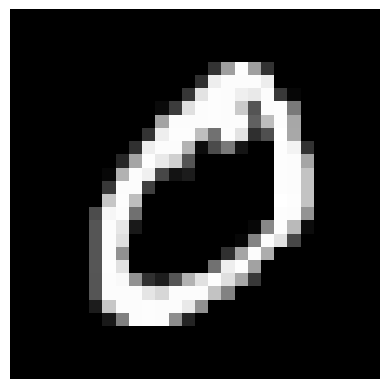

In [24]:
plt.imshow(X[1].reshape(28,28), cmap="gray")
plt.axis('off')
plt.show()

In [8]:
som = SOM(input_dim=784, map_size=(2,5))

In [9]:
som.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.05, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

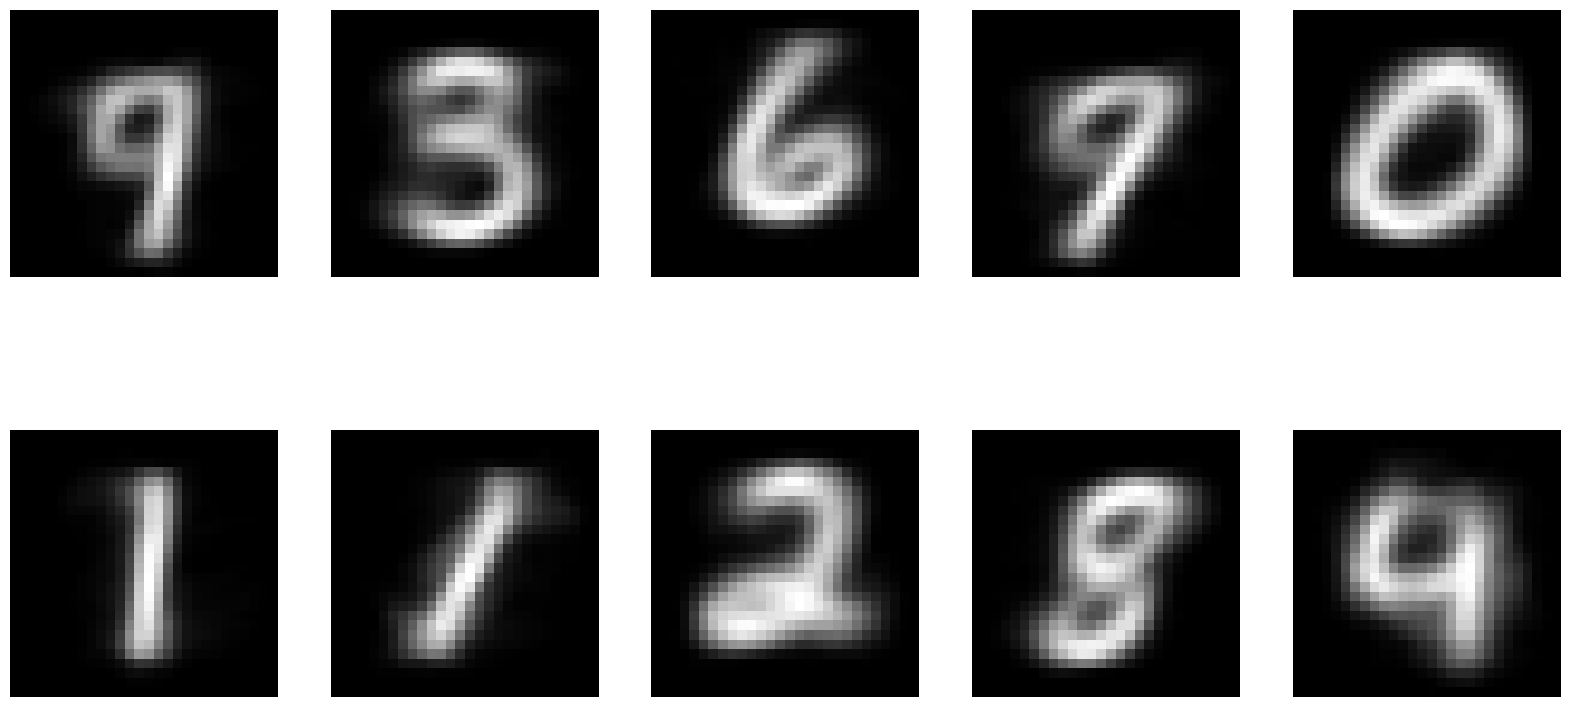

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

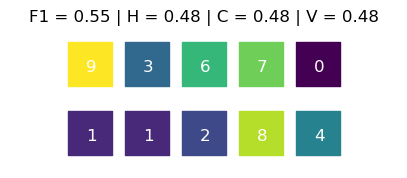

In [43]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som,X,y)
indices = som.neighbor_indices
idx = indices[0].reshape(-1)
idy = indices[1].reshape(-1)
idx = np.abs(np.max(idx) - idx) 

plt.figure(figsize=(5,1.8))
plt.scatter(idy, idx, c=labels, marker="s", s=1000)
for i in range(10):
  for j in range(len(labels)):
    if i == labels[j]:
      plt.text(idy[j]-0.07, idx[j]-0.1, s=i, fontsize=12, c="w")
plt.xlim((np.min(idy) - 1.4 , np.max(idy) + 1.4))
plt.ylim((np.min(idx) - 0.5 , np.max(idx) + 0.5))
plt.axis("off")
plt.title(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")
plt.show()

In [29]:
som2 = SOM(input_dim=784, map_size=(5,5))

In [31]:
som2.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.05, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

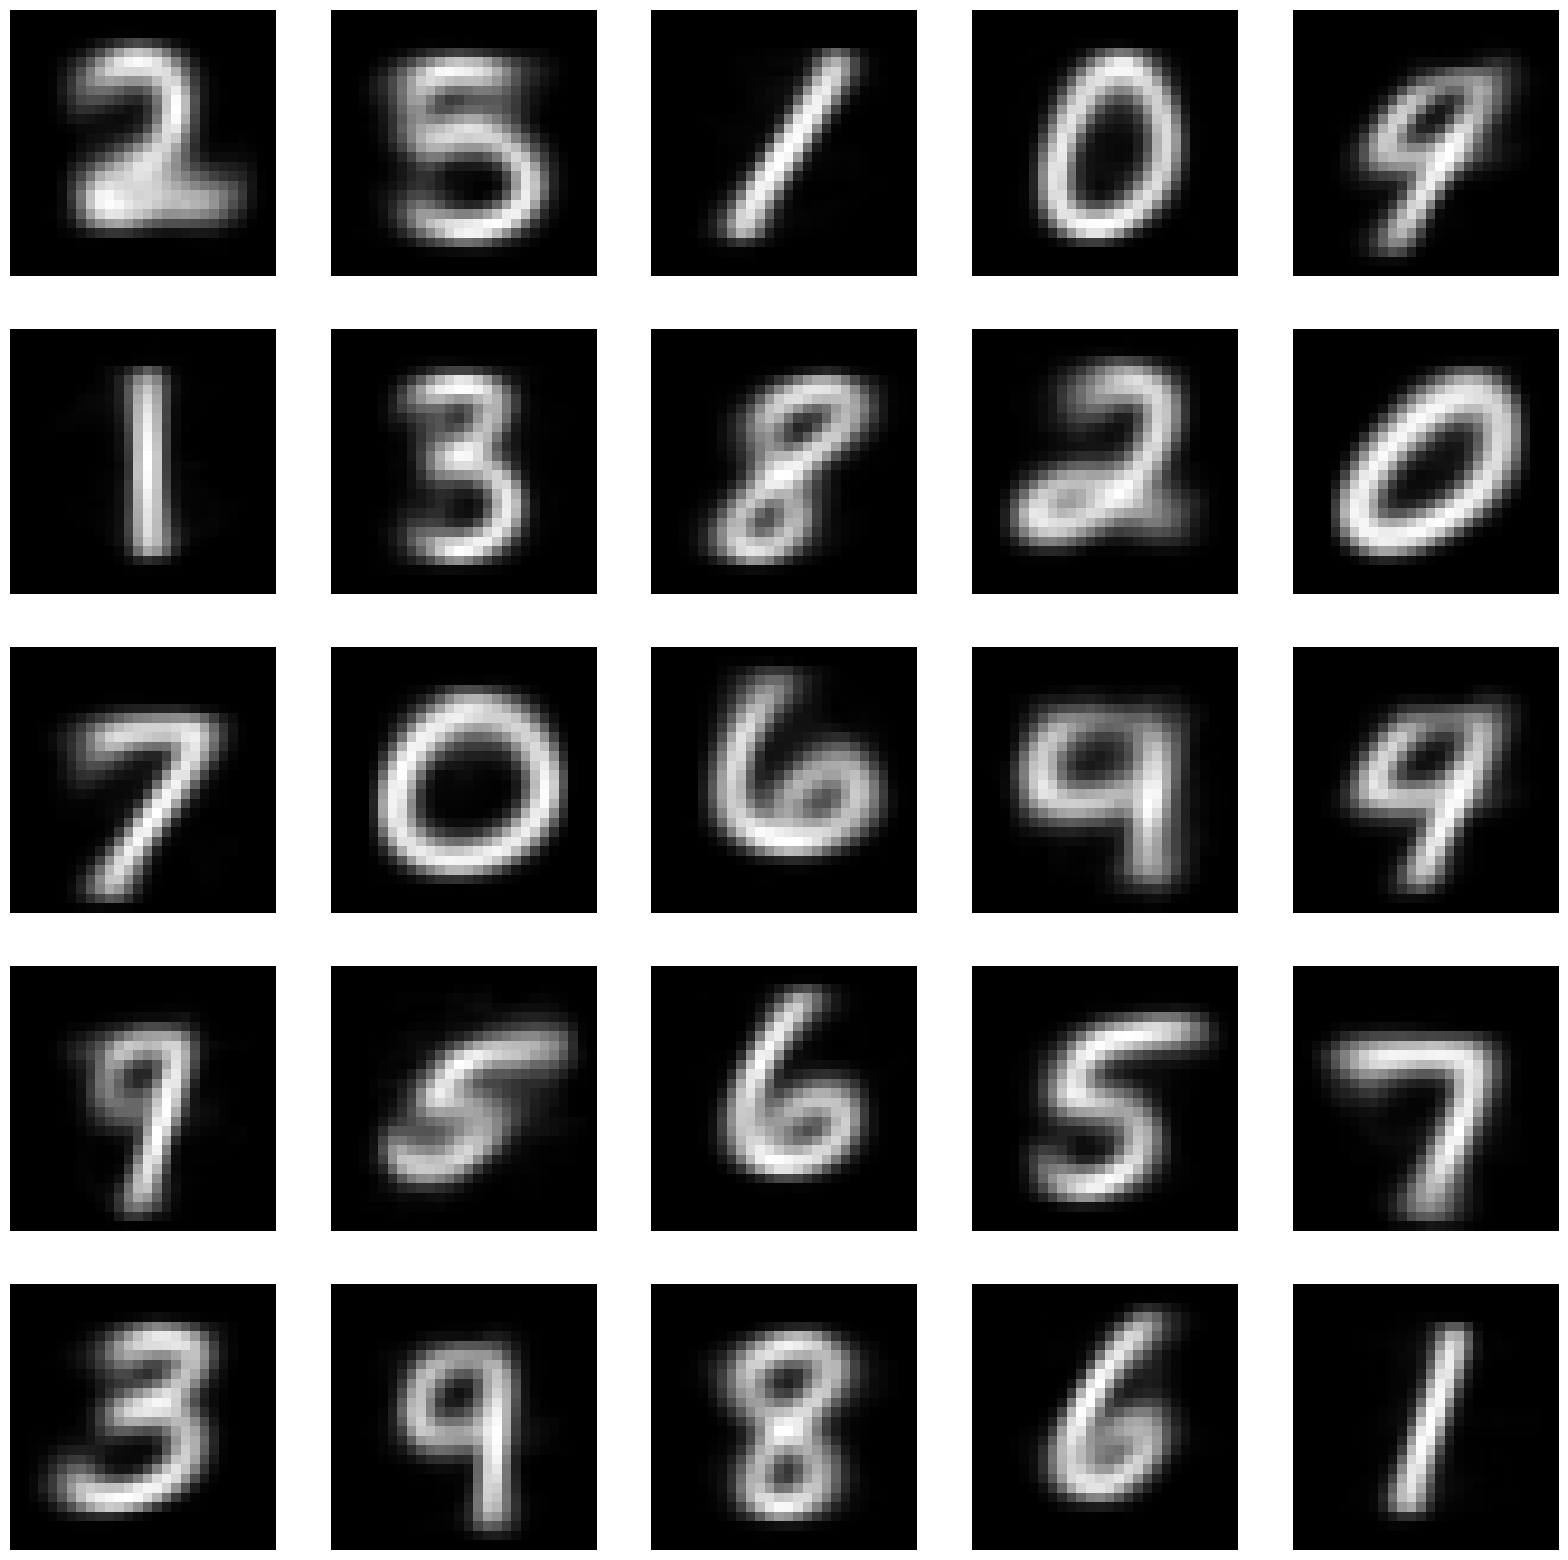

In [33]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som2.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

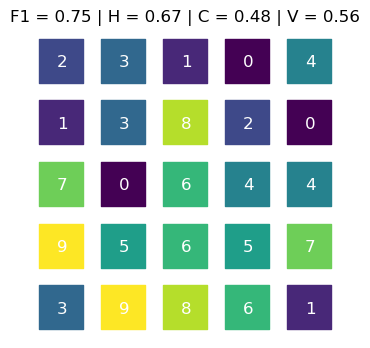

In [42]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som2,X,y)
indices = som2.neighbor_indices
idx = indices[0].reshape(-1)
idy = indices[1].reshape(-1)
idx = np.abs(np.max(idx) - idx) 

plt.figure(figsize=(4,4))
plt.scatter(idy, idx, c=labels, marker="s", s=1000)
for i in range(10):
  for j in range(len(labels)):
    if i == labels[j]:
      plt.text(idy[j]-0.07, idx[j]-0.1, s=i, fontsize=12, c="w")
plt.xlim((np.min(idy) - 0.5 , np.max(idy) + 0.5))
plt.ylim((np.min(idx) - 0.5 , np.max(idx) + 0.5))
plt.axis("off")
plt.title(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")
plt.show()

In [38]:
som3 = SOM(input_dim=784, map_size=(10,10))

In [39]:
som3.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.05, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

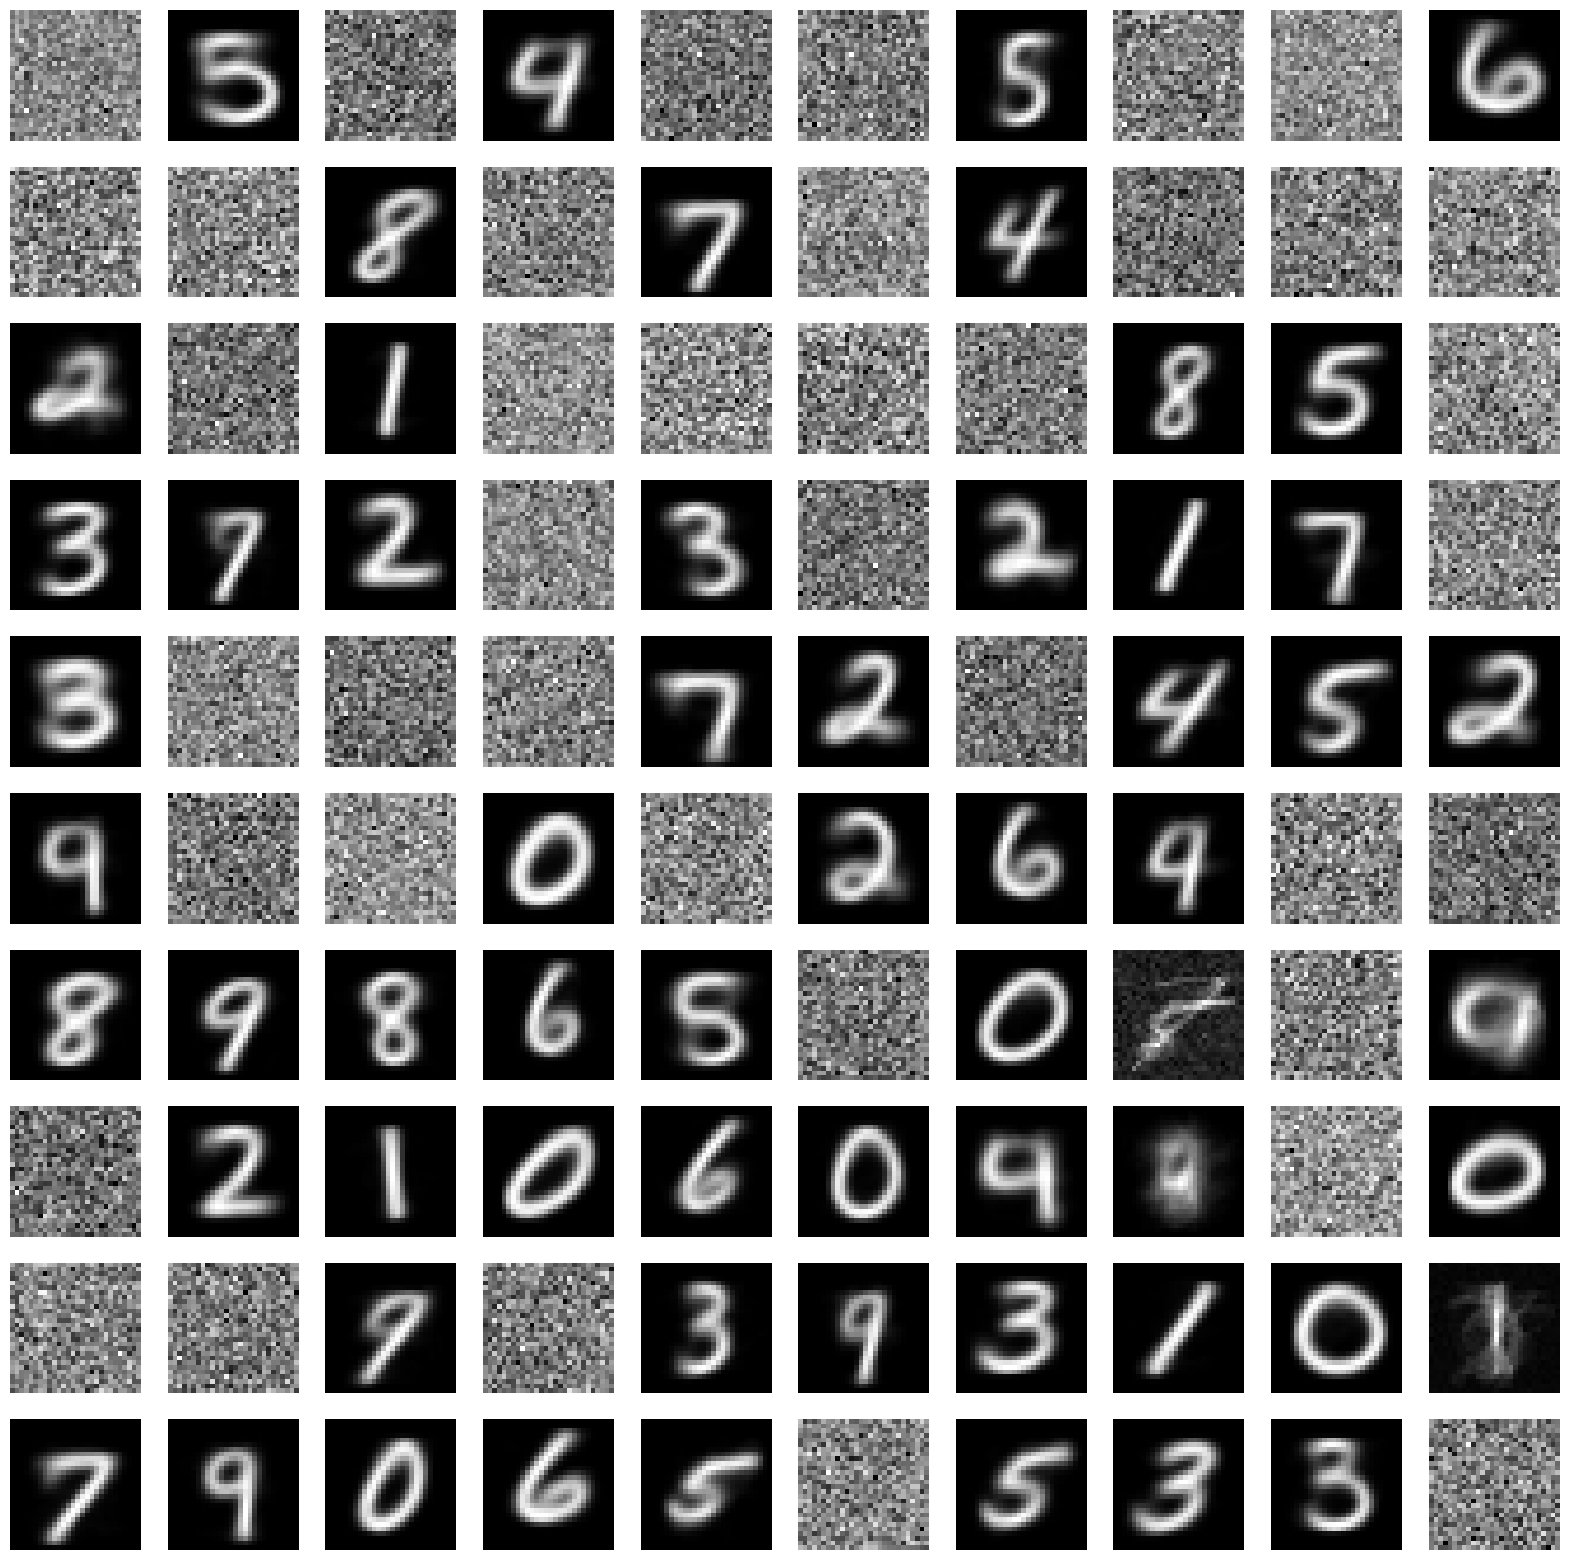

In [45]:
fig, axs = plt.subplots(10,10, figsize=(20, 20))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som3.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

In [48]:
labels.shape 

(66,)

In [50]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som3,X,y)
print(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")

F1 = 0.16 | H = 0.74 | C = 0.43 | V = 0.54


In [51]:
som3.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.01, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

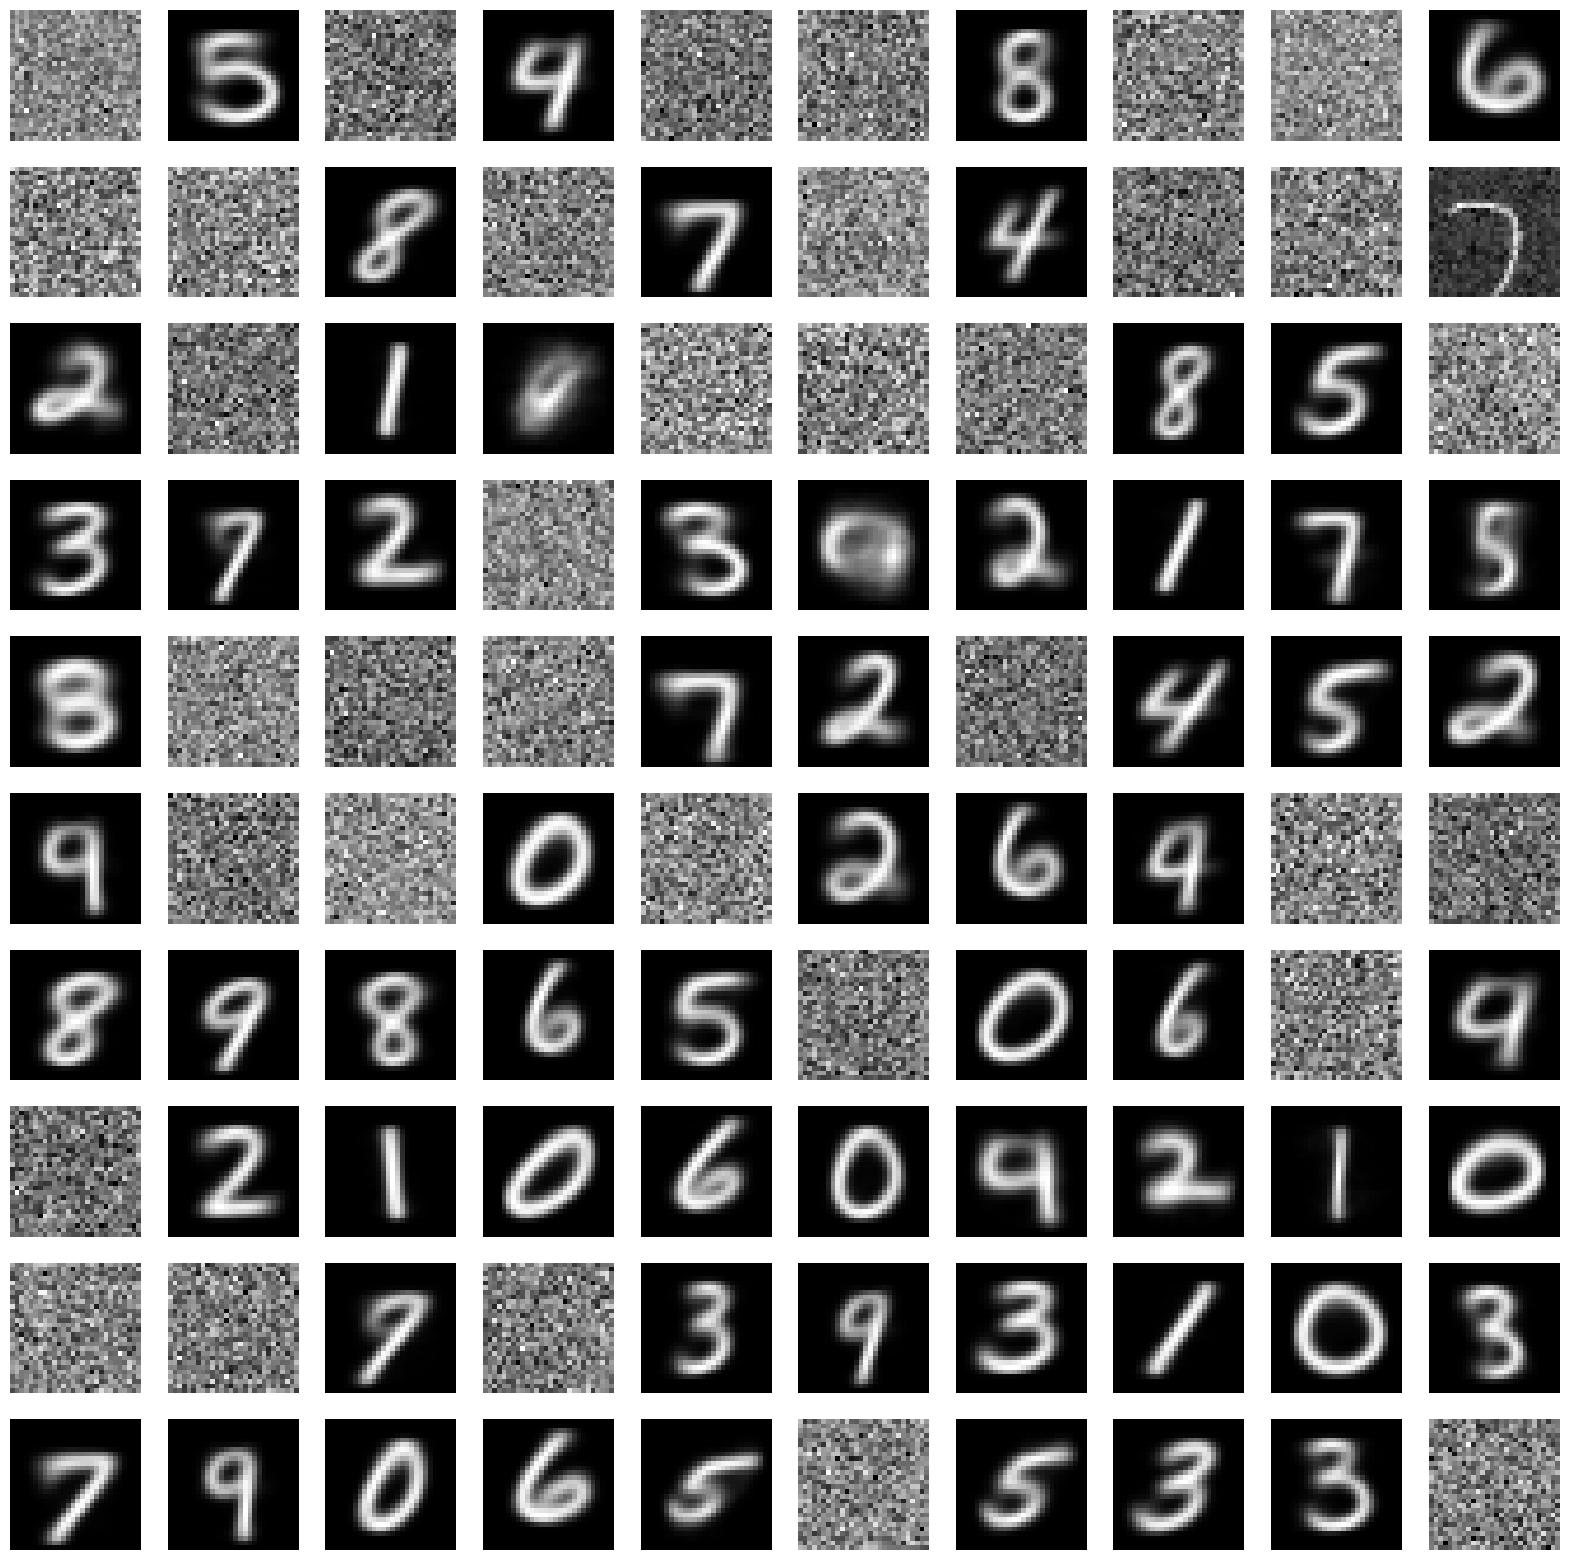

In [52]:
fig, axs = plt.subplots(10,10, figsize=(20, 20))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som3.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

In [54]:
labels.shape 

(71,)

In [53]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som3,X,y)
print(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")

F1 = 0.10 | H = 0.75 | C = 0.42 | V = 0.54


In [57]:
som4 = SOM(input_dim=784, map_size=(8,6))

In [58]:
som4.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.05, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

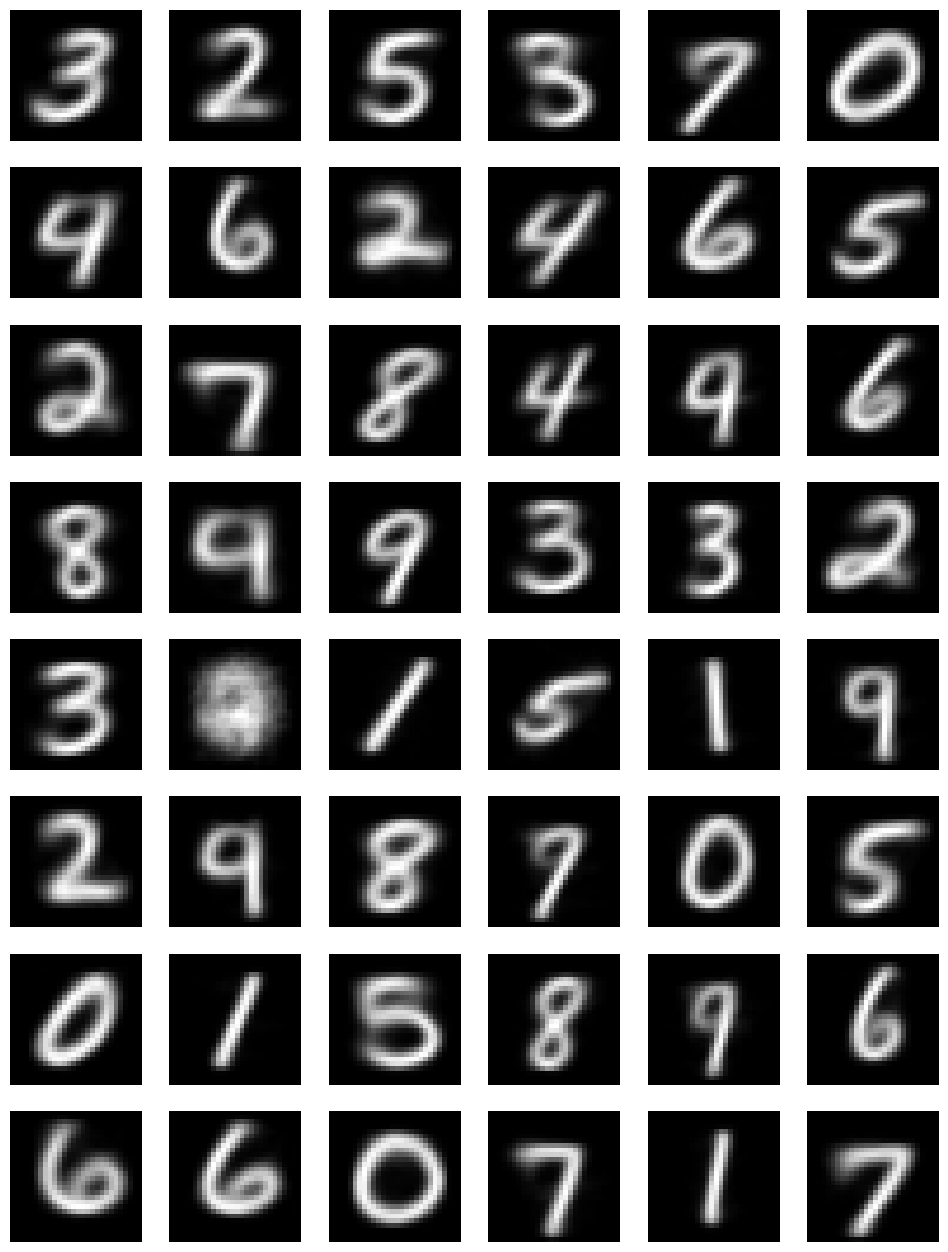

In [60]:
fig, axs = plt.subplots(8, 6, figsize=(12, 16))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som4.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

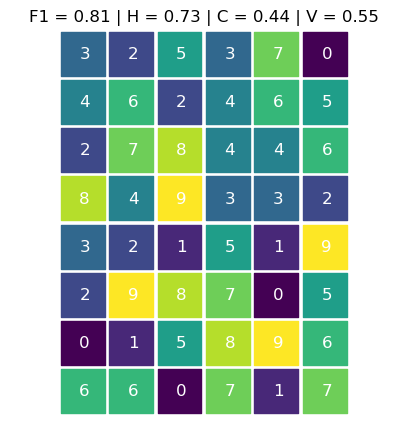

In [65]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som4,X,y)
indices = som4.neighbor_indices
idx = indices[0].reshape(-1)
idy = indices[1].reshape(-1)
idx = np.abs(np.max(idx) - idx) 

plt.figure(figsize=(5,5))
plt.scatter(idy, idx, c=labels, marker="s", s=1000)
for i in range(10):
  for j in range(len(labels)):
    if i == labels[j]:
      plt.text(idy[j]-0.07, idx[j]-0.1, s=i, fontsize=12, c="w")
plt.xlim((np.min(idy) - 1.5 , np.max(idy) + 1.5))
plt.ylim((np.min(idx) - 0.5 , np.max(idx) + 0.5))
plt.axis("off")
plt.title(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")
plt.show()

In [66]:
# hexagonal grid

In [76]:
som5 = SOM(28*28 , (5,5), topology="hexagonal")

In [77]:
som5.train(X, epochs=20, neighborhood_function=gaussian, learning_rate=0.05, sigma=0.1, learning_rate_decay=10,verbose=True)

 Epoch 20/20

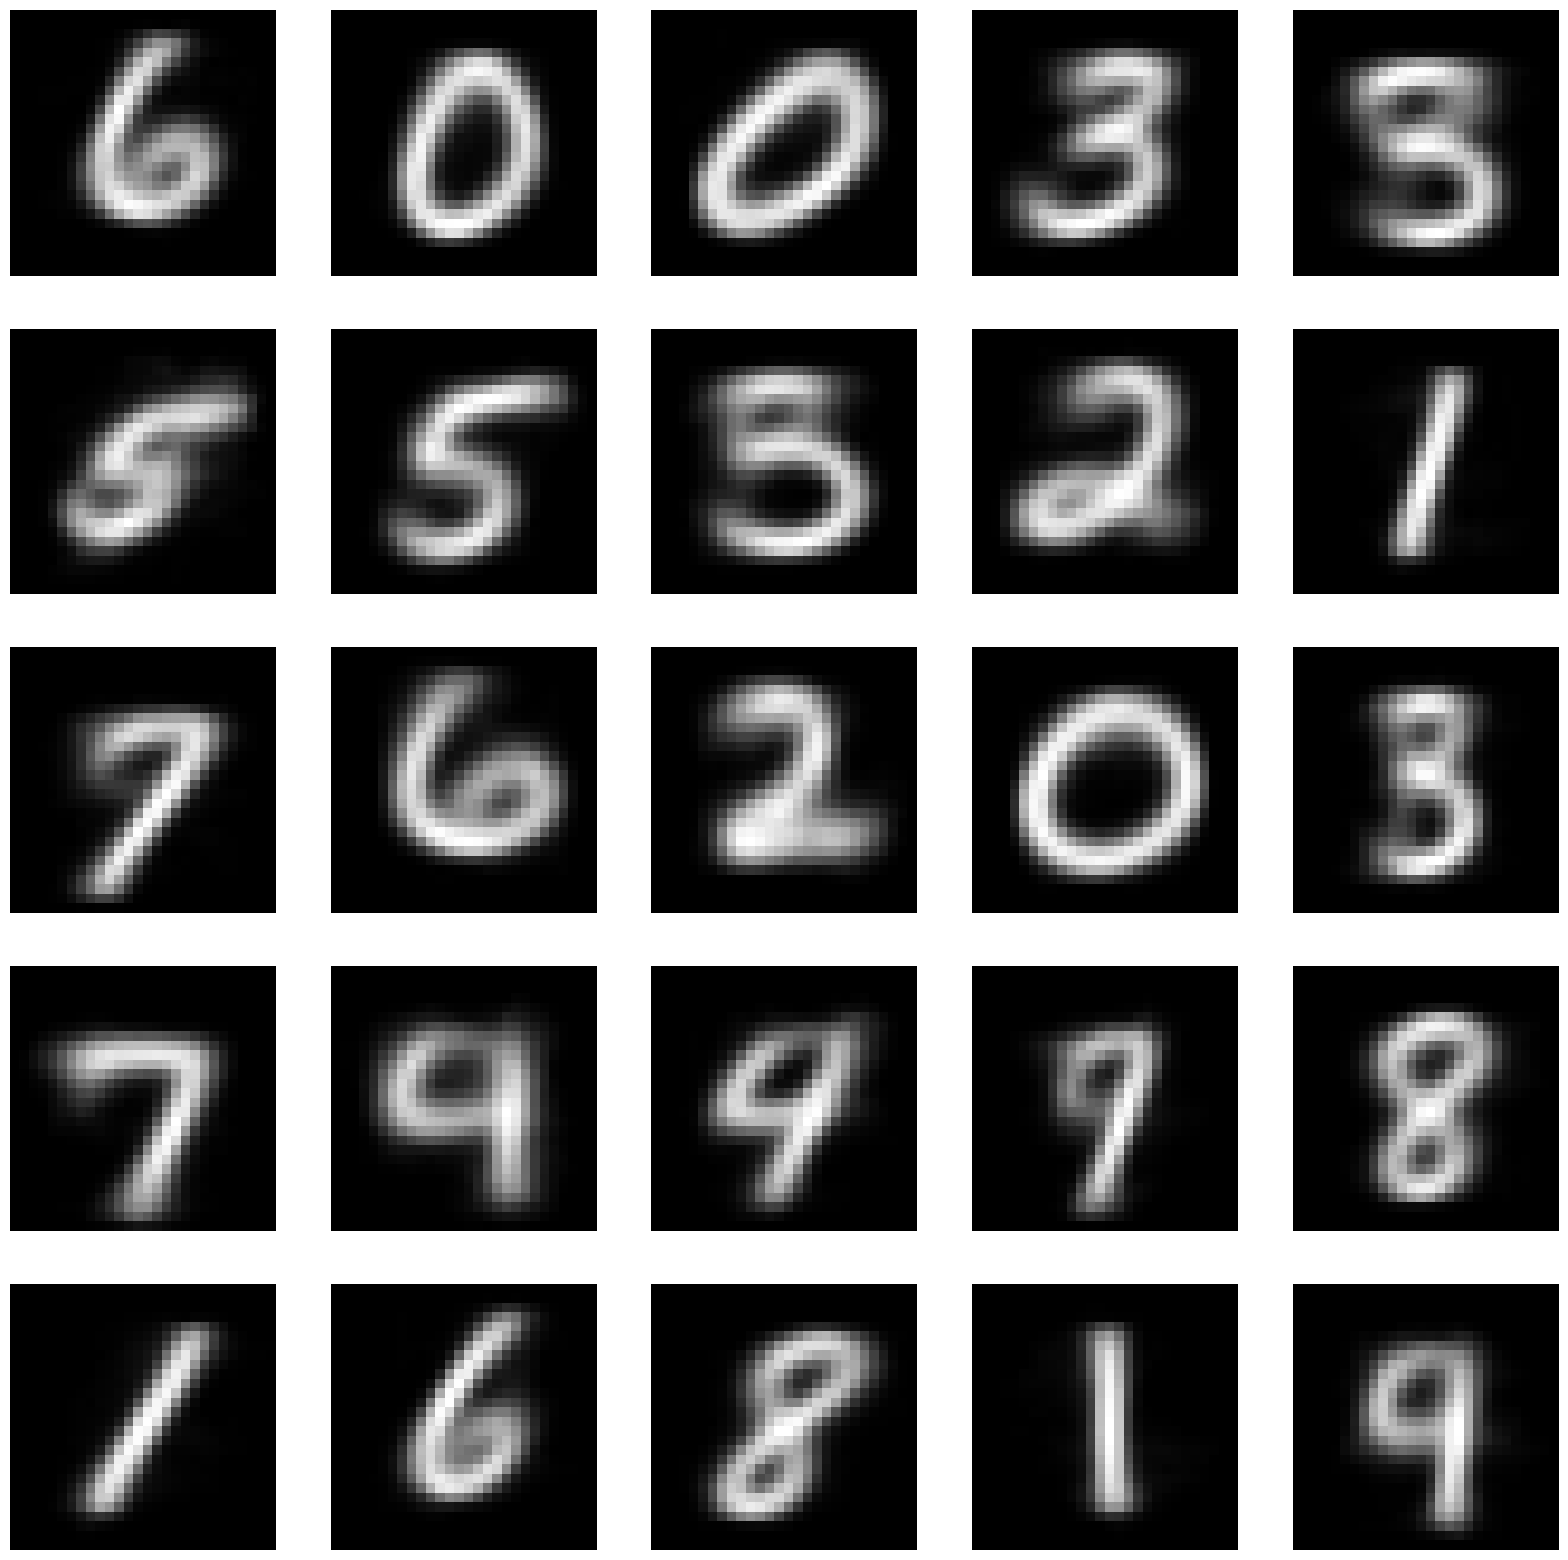

In [78]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(som5.weights[i,j].reshape(28,28), cmap="gray")
        axs[i,j].axis('off')

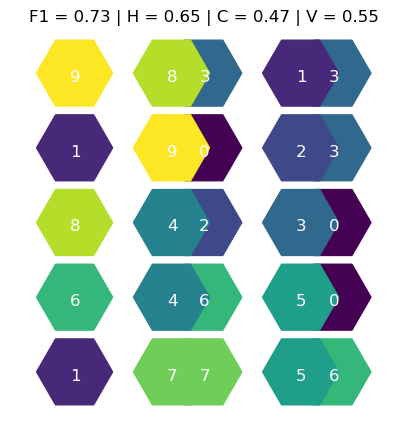

In [80]:
y_pred_relabeled, y_pred,f1, h_score,c_score,v_score, labels = get_scores_hex(som5,X,y)
indices = som5.neighbor_indices
idx = indices[0].reshape(-1)
idy = indices[1].reshape(-1)
# idx = np.abs(np.max(idx) - idx) 

plt.figure(figsize=(5,5))
plt.scatter(idx, idy, c=labels, marker="H", s=3000)
for i in range(10):
  for j in range(len(labels)):
    if i == labels[j]:
      plt.text(idx[j]-0.07, idy[j]-0.1, s=i, fontsize=12, c="w")
plt.xlim((np.min(idx) - 1 , np.max(idx) + 1))
plt.ylim((np.min(idy) - 0.5 , np.max(idy) + 0.5))
plt.axis("off")
plt.title(f"F1 = {f1:.2f} | H = {h_score:.2f} | C = {c_score:.2f} | V = {v_score:.2f}")

plt.show()

In [160]:
indices = som5.neighbor_indices

In [162]:
indices

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.8660254 , 0.8660254 , 0.8660254 , 0.8660254 , 0.8660254 ],
        [1.73205081, 1.73205081, 1.73205081, 1.73205081, 1.73205081],
        [2.59807621, 2.59807621, 2.59807621, 2.59807621, 2.59807621],
        [3.46410162, 3.46410162, 3.46410162, 3.46410162, 3.46410162]],

       [[0.5       , 1.5       , 2.5       , 3.5       , 4.5       ],
        [0.        , 1.        , 2.        , 3.        , 4.        ],
        [0.5       , 1.5       , 2.5       , 3.5       , 4.5       ],
        [0.        , 1.        , 2.        , 3.        , 4.        ],
        [0.5       , 1.5       , 2.5       , 3.5       , 4.5       ]]])

In [205]:
tmp = som5.weights.reshape(25,784)

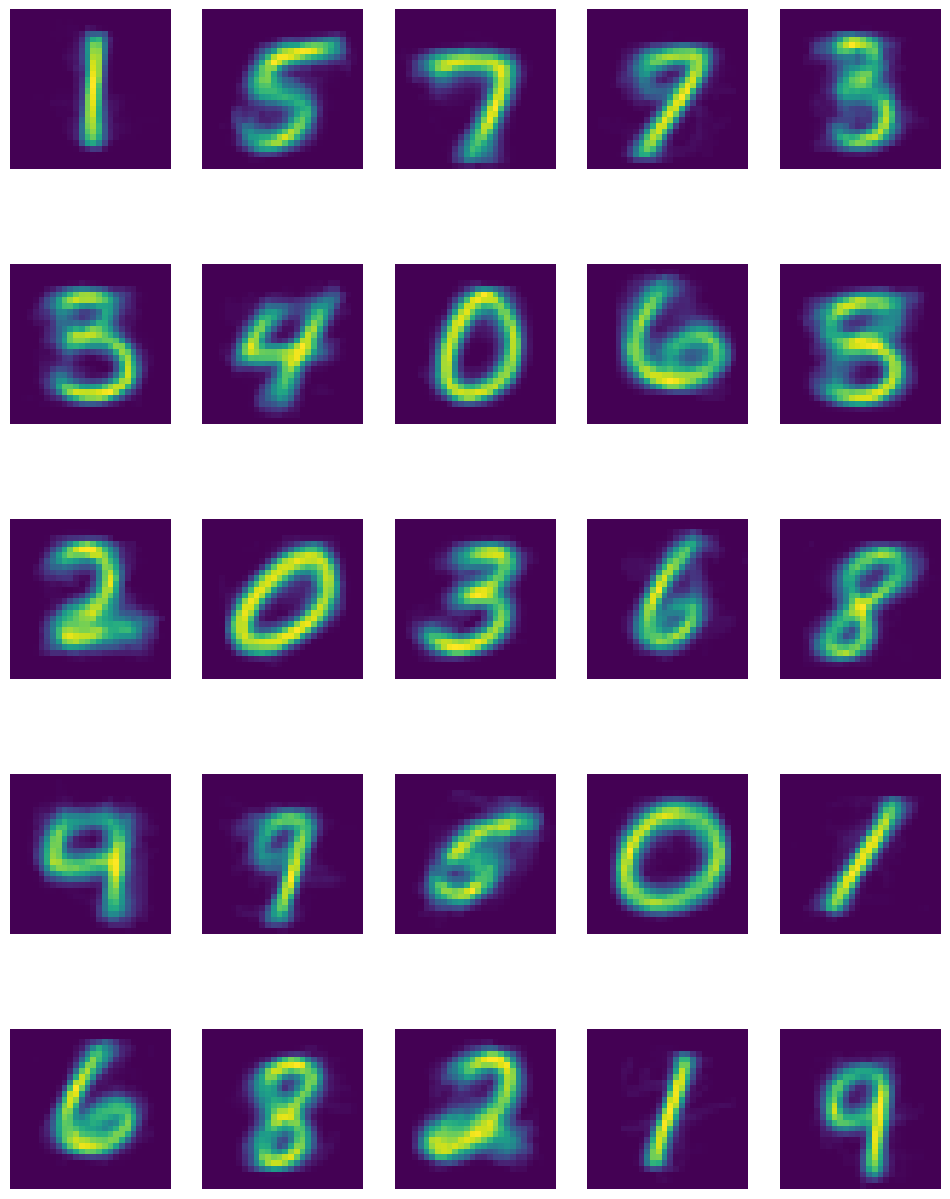

In [204]:
fig, axs = plt.subplots(5, 5, figsize=(12, 16))
axs = axs.flatten()




for i, ax in enumerate(axs):
    ax.imshow(np.asarray(tmp[i]).reshape(28,28))
    ax.axis('off')

In [207]:
import seaborn as sns
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, confusion_matrix,f1_score
from scipy.optimize import linear_sum_assignment
import warnings

In [361]:
labels = np.argmax(conf_matrix,axis=0)
y_pred_relabeled = np.zeros_like(y_pred)
for i in range(len(y_pred)):
    for j in range(len(labels)):
        if y_pred[i] == j:
            y_pred_relabeled[i] = labels[j]
            break

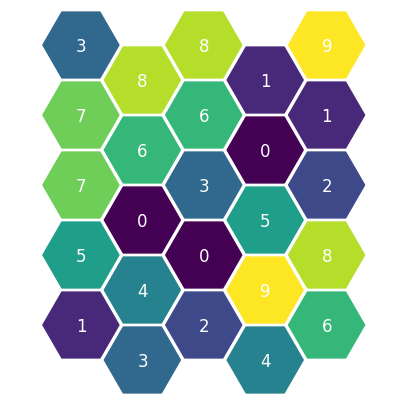

In [381]:
indices = som5.neighbor_indices
idx = indices[0].reshape(-1)
idy = indices[1].reshape(-1)

AttributeError: ignored

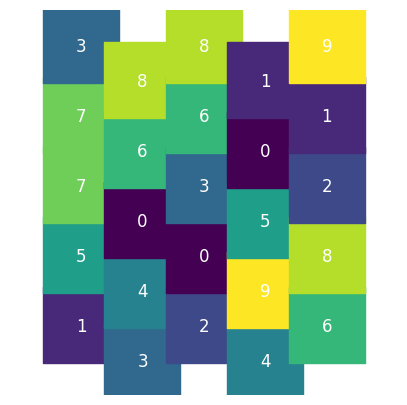